# <center> Insurance Forecast - Regression

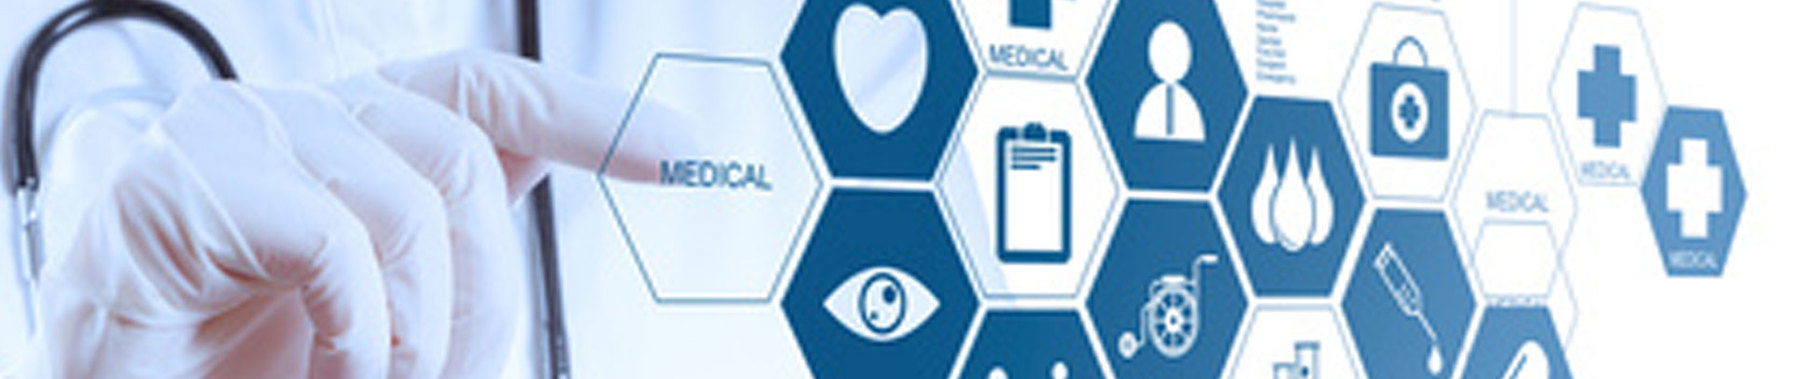

## Introduction

In this notebook, I'll be focusing on performing machine learning (ML) models for a multiclass regression to predict insurance forecast ([Data Source](https://www.kaggle.com/datasets/mirichoi0218/insurance)). Also, I'll go in every step needed taken to correctly do so. Firstly, I'll do some basic exploration in the data to underestend it and then prepare it for fit in the model. To make a inicial seach to see which models better fit the data (preset more accurate) will be used `RandomizedSearchCV` which is much faster than GridSearchCV, but not necessarily presents the best result (because it's random 😁). To evaluate these models the metrics that will be used are:

* Mean Absolute Error
* Mean Squared Error
* Root Mean Squared Error
* Root Mean Squared Logarithmic Error
* R Square

**Data content:**

- **age**: age of primary beneficiary

- **sex**: insurance contractor gender, female, male

- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- **children**: Number of children covered by health insurance / Number of dependents

- **smoker**: Smoking

- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- **charges**: Individual medical costs billed by health insurance

### Libraries

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='viridis',
#              font='Lucida Calligraphy',
              font_scale=1.3,
              color_codes=True,
              rc=None)
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

### Dataset

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='viridis')

,count,mean,std,min,25%,50%,75%,max
age,1338.000000,39.207025,14.049960,18.000000,27.000000,39.000000,51.000000,64.000000
bmi,1338.000000,30.663397,6.098187,15.960000,26.296250,30.400000,34.693750,53.130000
children,1338.000000,1.094918,1.205493,0.000000,0.000000,1.000000,2.000000,5.000000
charges,1338.000000,13270.422265,12110.011237,1121.873900,4740.287150,9382.033000,16639.912515,63770.428010


* The dataset contains 6 columns with 1338 observations, and there are no missing values.
* There are some categorical features in our data - features in Dtype: object. So we will need to encode them into numeric later.
* However, the data types for some columns are not matched. Below will fixed the data types for those column before analysis performed.

## Basic Exploratory Data Analysis (EDA)

In this section will focused on initial data exploration before applying ML models.

In [6]:
df1 = df.copy()
#sex
le = LabelEncoder()
le.fit(df1.sex.drop_duplicates()) 
df1.sex = le.transform(df1.sex)
# smoker or not
le.fit(df1.smoker.drop_duplicates()) 
df1.smoker = le.transform(df1.smoker)
#region
le.fit(df1.region.drop_duplicates()) 
df1.region = le.transform(df1.region)

<AxesSubplot:>

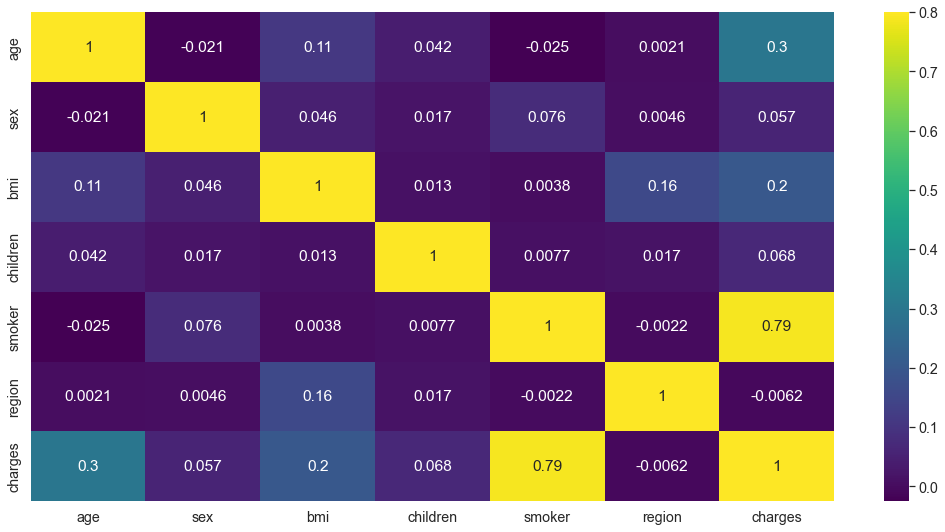

In [7]:
corrmat = df1.corr(method='pearson')
fig, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(corrmat, vmax=.8, annot=True, cmap='viridis')

As can be seen here, the variables that most influence the price are whether the user is a smoker or not, his age and BMI, respectively.

Text(0.5, 0, '')

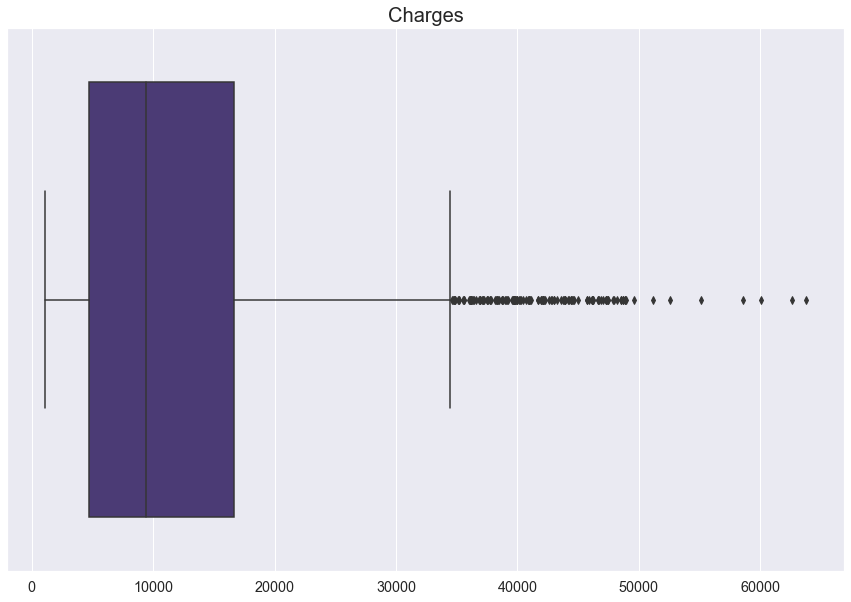

In [8]:
plt.figure(figsize=(15,10))
plt.title('Charges', fontsize=20)
fig = sns.boxplot(df['charges'])
fig.set_xlabel('',fontsize=15)

In the boxplot, it can be observed that there are outliers in the variable algo, so it is expected that such points affect the learning of the algorithms since they can cause the model's function to be 'pulled' by these values. However, the removal of these outliers will not be performed on this notebook.

Linear regression algorithms assume that the relationships between input and output variables are linear so the more strong these relationships more accurate the model will be.

Text(0.5, 1.0, 'Age X Charges - Smoker')

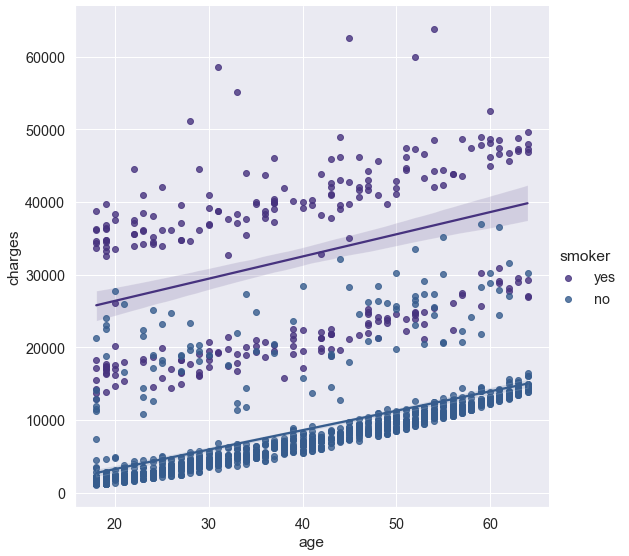

In [9]:
sns.lmplot(data=df, x="age", y="charges", hue="smoker", height=8, aspect=1)
ax.set_title('Age X Charges - Smoker')

Text(0.5, 1.0, 'BMI X Charges - Smoker')

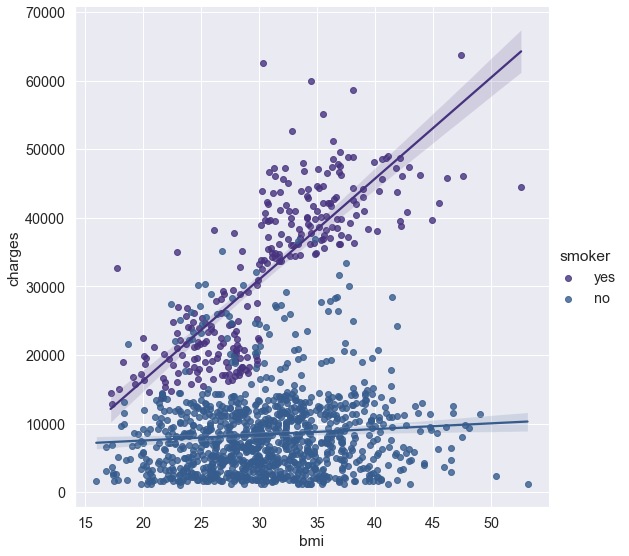

In [10]:
sns.lmplot(data=df, x='bmi', y='charges', hue='smoker', height=8, aspect=1)
ax.set_title('BMI X Charges - Smoker')

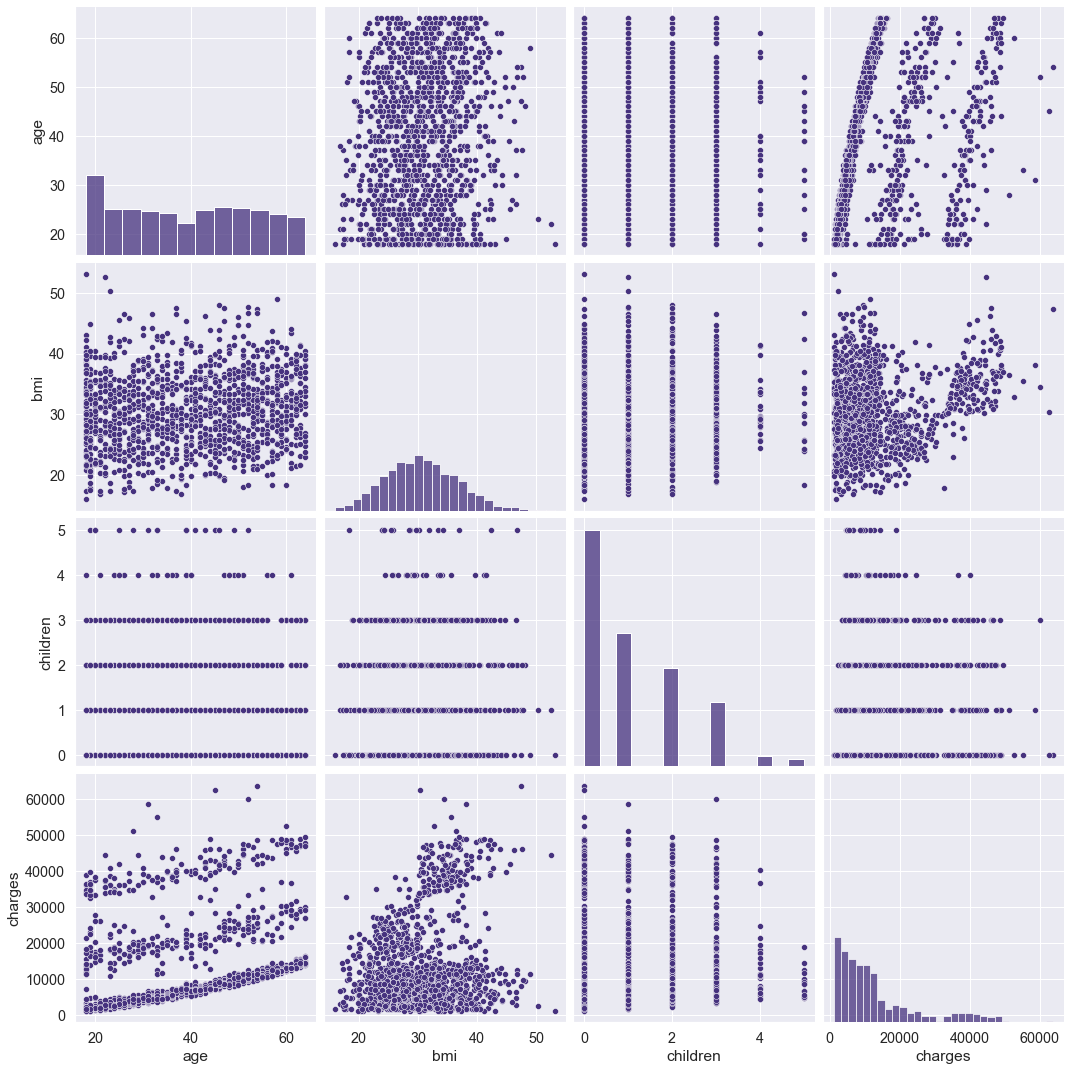

In [11]:
sns.pairplot(data=df, height=3.8, aspect=1)

Before entering in the next section it's worth to mention that a deeper analysis could be done, but the main point is to model and evaluate the algorithms.

## Data Preprocessing

In this section, I will be preprocessing the data to fit it in the model.

**The following steps are applied to preprocess the data:**

* One hot encoding the categorical features - transform categorical features into numerical feature, since it's necessary to into into the model
* Scaling the features using the standard scaler - normalizes the data into a same scale

In [12]:
X = df.copy()
y = X.pop('charges')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
#y = np.log(y) # log transform target instead of standardizing

## Modelling

Now that the data is ready, I will be fitting it into several regression models such as `Linear Regression`, `K-Nearest Neighbor`, `Decision Tree and Random Forest`, and `XGBoost`.

**Steps involved in this section:**

* Brief description of the models to be used
* RandomizedSearchCV to determine the models that best fit the data
* Creating train and test dataset
* Use metrics and hyperparameters to improve models

**Linear Regression**

<img src='http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif'>

Source: [Linear Regression - PRIMO.ai](https://primo.ai/index.php?title=Linear_Regression)

Linear Regression is one of the most simple supervised machine learning algorithms. This basically consists of identifying the 'line of best fit' - the equation of this line that will be used for future forecasts. To find such a line, the model performs iterations so that it presents the smallest possible error between the line and the datapoints. If you are interested in delving more into linear regression, check out this https://primo.ai/index.php?title=Linear_Regression .

**Decision Tree**

<img src='https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/df/de/Decision-Tree.component.xl.ts=1640802170790.png/content/adobe-cms/us/en/topics/decision-trees/jcr:content/root/table_of_contents/intro/complex_narrative/items/content_group_1423241468/image'>

Source: [What is a Decision Tree | IBM](https://www.ibm.com/topics/decision-trees)
Decision Tree is one of the most popular machine learning algorithms because it is very versatile - it can be used for both regression and classification. This, as its name implies, works in the form of decision-making. The algorithm uses the sampling of data by splitting the it into parts. The tree structure consists of a root node, branches, internal nodes and leaf nodes. The root node represents the most important variable of the database, branches are pretty explanatory, internal nodes are the other variables - which are ordered from most to least important in the tree structure, and the leaf nodes is the end point where a decision is made.

**Random Forest**

<img src='https://1.cms.s81c.com/sites/default/files/2020-12-07/Random%20Forest%20Diagram.jpg'>

Source: [What is Random Forest?](https://www.ibm.com/topics/decision-trees)

Random forests are a ensemble learning technique that is based on decision trees. While an individual decision tree has one result and a narrow range of groups, the forest guarantees a more accurate result, with a greater number of groups and decisions. It has the added benefit of bringing randomness to the model, as each tree selects random variables from the main database.

**k-Nearest Neighbours**

<img src='https://miro.medium.com/max/1200/0*OltO4Txr-D0lPWNL.png'>

Source: [K-Nearest Neighbor. A complete explanation of K-NN | by Antony Christopher | The Startup | Medium](https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4)

kNN is a very simple algorithm, which can also be used for both regression and classification. Basically, the algorithm considers that neighboring data points are not similar. This similarity is measured through the distance between the data points, which can be Euclidean distance, Hamming distance, Manhattan distance, and Minkowski distance. The k refers to the number of neighbors - in the case of regression, the mean can be taken from these k neighbors for the prediction and in the case of classification the frequency.

**AdaBoost**

Source: [AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique that is used as an Ensemble Method in Machine Learning. Learn more!](https://www.mygreatlearning.com/blog/adaboost-algorithm/)

AdaBoost (Adaptive Boosting) algorithm is a Boosting technique used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights assigned to incorrectly classified instances. Boosting is used to reduce bias as well as variance for supervised learning. It works on the principle of learners growing sequentially. Except for the first one, each subsequent learners is developed from previously grown learners. In simple words, weak learners are made strong. To learn more about AdaBoost check this [article](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe).

**Gradient Boosting**

<img src='https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-Lw6zezdliKWkGknCJ6R%2F-Lw70ZzNl5AgerhBsp-v%2Fimage.png?alt=media&token=5df440f0-a102-454e-9d43-e07549dd5334'>

Source: [Gradient Boosting - AI Wiki](https://machine-learning.paperspace.com/wiki/gradient-boosting) 

XGBoost is an algorithms that can be applyed to both regression and classification.
"Gradient boosting (derived from the term gradient boosting machines) is a popular supervised machine learning technique for regression and classification problems that aggregates an ensemble of weak individual models to obtain a more accurate final model ... XGBoost is a very popular gradient boosting framework that is fast, uses some clever tricks to obtain more accurate results, and is easy to parallelize.  " - [Gradient Boosting - AI Wiki](https://machine-learning.paperspace.com/wiki/gradient-boosting)  

### Best Models to fit the data

In this section

In [13]:
model_params = {
    'linear_regression' : {
        'model' : LinearRegression(),
        'params' : {
#            'penalty' : np.array(['l1', 'l2', 'elasticnet', 'none']),
#            'max_iter' : np.arange(25, 250, 25),
#            'C' : np.arange(0.01, 1, 0.01),
#            'solver' : np.array(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
        }
    },
    'decision_tree' : {
        'model': DecisionTreeRegressor(),
        'params': {
#            'criterion': np.array(["squared_error", "friedman_mse", "absolute_error", "poisson"]),
#            'max_depth': np.array([None, 1, 3, 5, 7, 8, 9]),
#            'min_samples_split' : np.arange(1, 4, 1),
#            'min_samples_leaf' : np.arange(1, 4, 1),
#            'max_features' : np.array([None, "auto", "sqrt", "log2"])
        }
    },
    'random_forest' : {        
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': np.arange(50, 650, 50),
            'max_features' : np.array([None, "auto", "sqrt", "log2"]),
            'max_depth' : np.array([None, 1, 3, 5, 7, 8, 9]),
            'min_samples_split' : np.arange(1, 4, 1),
            'min_samples_leaf' : np.arange(1, 4, 1),
            'bootstrap': np.array([False, True])
        }
    },
    'knn': {
        'model': KNeighborsRegressor(),
        'params' : {
#            'n_neighbors' : [2, 3, 4, 5, 7],
#            'weights' : np.array(['uniform', 'distance']),
#            'leaf_size' : np.arange(2, 60, 2),
#            'p' : np.arange(1, 6, 1)
        }        
   },
    'adaboost' : {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': np.arange(50, 650, 50),
            'learning_rate' : np.arange(1, 0.01, -0.1),
            'loss' : np.array(['linear', 'square', 'exponential'])
        }
    },
    'xgb' : {
        'model' : XGBRegressor(),
        'params' : {
            'n_estimators': np.arange(50, 650, 50),
            'learning_rate' : np.arange(1, 0.01, -0.1),
            'eta': np.array([.03, .07, 0.1]), #(eta or shrinkage)
            'min_child_weight' : np.array([.5, 1]),
            'max_depth' : np.array([4, 5, 6, 7])
        }
    }
}

In [14]:
scores = []

for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [15]:
scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
scores.sort_values(by='best_score', ascending=False)

,model,best_score,best_params
2,random_forest,0.858391,"{'n_estimators': 50, 'min_samples_split': 3, '..."
4,adaboost,0.830890,"{'n_estimators': 600, 'loss': 'linear', 'learn..."
5,xgb,0.799871,"{'n_estimators': 500, 'min_child_weight': 1.0,..."
3,knn,0.753190,{}
0,linear_regression,0.746862,{}
1,decision_tree,0.707976,{}


Apparently, `Random Forest`, `AdaBoost` and `XGBoost` were the best performers for this database so to further evaluation these will be used.\
Note: _The code was run twice, the first time no hyperparameters were used._

### Split train and test data

Train/Test Split involves splitting the dataset into training and testing sets respectively. After which, you train with the training set and test with the testing set. This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
[scores.sort_values(by='best_score', ascending=False)['best_params'][2], 
scores.sort_values(by='best_score', ascending=False)['best_params'][5],
scores.sort_values(by='best_score', ascending=False)['best_params'][4],]

[{'n_estimators': 50,
  'min_samples_split': 3,
  'min_samples_leaf': 2,
  'max_features': 'auto',
  'max_depth': 5,
  'bootstrap': True},
 {'n_estimators': 500,
  'min_child_weight': 1.0,
  'max_depth': 4,
  'learning_rate': 0.20000000000000018,
  'eta': 0.1},
 {'n_estimators': 600, 'loss': 'linear', 'learning_rate': 0.6000000000000001}]

In [18]:
#RandomForest
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=3, min_samples_split=3, bootstrap=True)
rf_model.fit(X_train, y_train)
#Predicting vector for RandomForest
y_pred_rf = rf_model.predict(X_test)

In [19]:
#XGBoost
xgb_model = XGBRegressor(n_estimators=300, min_child_weight=1, max_depth=4, learning_rate=0.1, eta=0.07)
xgb_model.fit(X_train, y_train)
#Predicting vector for XGBoost
y_pred_xgb = xgb_model.predict(X_test)

In [20]:
#AdaBoost
ada_model = AdaBoostRegressor(n_estimators=600, loss='linear', learning_rate=1)
ada_model.fit(X_train, y_train)
#Predicting vector for AdaBoost
y_pred_ada = ada_model.predict(X_test)

### Model Evaluation

In this section,    . If to understand more about these metrics please check [this](https://www.kaggle.com/code/vipulgandhi/how-to-choose-right-metric-for-evaluating-ml-model/notebook).

In [21]:
evaluation = []

def metrics (model, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(mean_squared_error(y_test, y_pred)**0.5, 3)
    rmsle = round(mean_squared_log_error(y_test, y_pred), 3)
    r_squared = round(r2_score(y_test, y_pred), 3)
    return [model, mae, mse, rmse, rmsle, r_squared]

rf = metrics('random_forest', y_test, y_pred_rf)
xgb = metrics('xgboost', y_test, y_pred_xgb)
ada = metrics('ada_boost', y_test, y_pred_ada)

In [22]:
compare = pd.DataFrame([rf, xgb, ada], columns=('model', 'mae', 'mse', 'rmse', 'rmsle', 'r_2'))
compare.sort_values(by='r_2', ascending=False).style.background_gradient(cmap='viridis').hide_index()

model,mae,mse,rmse,rmsle,r_2
random_forest,2430.692000,16349480.754000,4043.449000,0.159000,0.897000
xgboost,2578.686000,18409570.106000,4290.637000,0.179000,0.884000
ada_boost,3824.171000,21644435.235000,4652.358000,0.330000,0.864000


It seems that indeed Random Forest is the best algorithm for this particular dataset because it presented a smaller error than the others and a greater correlation between the real values and the predicted values (R^2). However, it is worth noting that further data processing could result in a different result.

**Bonus**

Text(0.5, 0, 'y_test')

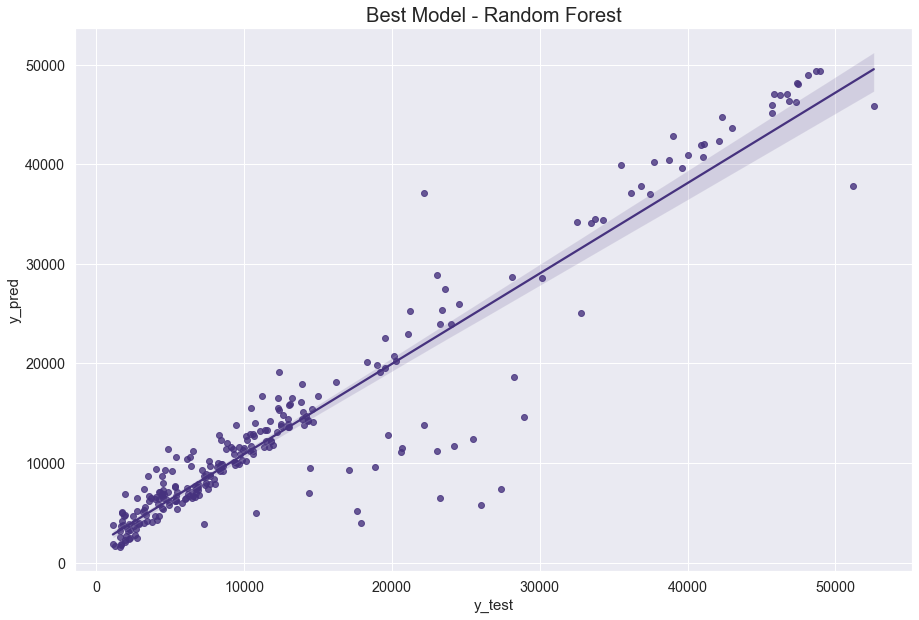

In [23]:
plt.figure(figsize=(15,10))
plt.title('Best Model - Random Forest', fontsize=20)
fig = sns.regplot(x=y_test, y=y_pred_rf)
fig.set_ylabel("y_pred",fontsize=15)
fig.set_xlabel("y_test",fontsize=15)

Those data points spread apart are probably the outliers mentioned before which probably harmed the model's performance.

# <center> References

* [Machine Learning with Python - Introduction to Machine Learning | Coursera](https://www.coursera.org/learn/machine-learning-with-python)
* [How to Choose Right Metric for Evaluating ML Model | Kaggle](https://www.kaggle.com/code/vipulgandhi/how-to-choose-right-metric-for-evaluating-ml-model/notebook)